In [166]:
import numpy as np
import pandas as pd
import warnings
import riskfolio as rp
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2%}'.format

In [167]:
xl = pd.ExcelFile('wartosci_walorow_12_22.xlsx')
sheets = xl.sheet_names

merged = xl.parse(sheets.pop(0))
print(sheets)

for sheet in sheets:
    data = xl.parse(sheet)    
    merged = merged.merge(data, on='Date', how='left') 

xl.close()


['MSCI ACWI', 'MWITR', 'TBSP', 'EURPLN', 'Bloomberg Barclays Global Aggre', 'Gold spot price', 'Global aggregate euro hdg', 'EURO STOXX 50 Daily Leverage', 'Bloomberg Barclays Global Corpo']


In [168]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 0 to 455
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 456 non-null    datetime64[ns]
 1   GovBondG7            456 non-null    float64       
 2   ACWI                 421 non-null    float64       
 3   Mwig40tr             156 non-null    float64       
 4   TBSP                 192 non-null    float64       
 5   EURPLN               255 non-null    float64       
 6   GlobalCorporate      124 non-null    float64       
 7   Gold                 456 non-null    float64       
 8   GABHDG               62 non-null     float64       
 9   EURO_STOXX_Leverage  253 non-null    float64       
 10  Fallen_Angels        79 non-null     float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 42.8 KB


In [169]:
assets = merged.columns[1:]
price_changes = merged[assets].pct_change()
price_changes.set_index(merged['Date'], inplace=True)

In [170]:
price_changes.to_excel('oryginal_price_changes.xlsx')

In [192]:
euro_assets = ['ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG', 'EURO_STOXX_Leverage', 'Fallen_Angels']
pln_assets = ['Mwig40tr', 'TBSP']

pln = merged[euro_assets].apply(lambda x: x * merged['EURPLN'])
pln_chng = pln.pct_change()
pln_chng.set_index(merged['Date'], inplace=True)
pln_chng = pd.merge(price_changes[pln_assets], pln_chng, left_index=True, right_index=True)

In [193]:
#pln_chng.to_excel('pln_price_changes2.xlsx')
pln_chng.to_csv('pln_price_changes2.csv', float_format='%.3f')

In [194]:
assets = pln_chng
assets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 456 entries, 1985-01-01 to 2022-12-01
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Mwig40tr             155 non-null    float64
 1   TBSP                 191 non-null    float64
 2   ACWI                 254 non-null    float64
 3   GovBondG7            254 non-null    float64
 4   GlobalCorporate      123 non-null    float64
 5   Gold                 254 non-null    float64
 6   GABHDG               61 non-null     float64
 7   EURO_STOXX_Leverage  252 non-null    float64
 8   Fallen_Angels        78 non-null     float64
dtypes: float64(9)
memory usage: 51.8 KB


In [195]:
def annullised_mean(series):
    return np.mean(series)*12

def annullised_std(series):
    return np.std(series) * np.sqrt(12)

def pstd(weights, cov_matrix):
    #variance = np.transpose(weights)@cov_matrix@weights
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(variance)

def pmean(weightsDf, means):  
    weights = weightsDf
    return np.sum(weights * means)

def portfolioMeasures(weights,means,cov_table):
    mu = np.apply_along_axis(pmean,1,weights, means=means)
    std = np.apply_along_axis(pstd,1,weights, cov_matrix=cov_table) 
    return np.array([mu,std]).T

In [196]:
perf60 = assets.iloc[-60:].agg(['mean', np.std])
perf60.iloc[0,:] = perf60.iloc[0,:]*12
perf60.iloc[1,:] = perf60.iloc[1,:] * np.sqrt(12)
perf60

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,2.32%,0.00%,11.67%,2.38%,4.06%,11.94%,0.80%,15.18%,8.49%
std,21.69%,5.83%,18.02%,8.12%,9.34%,12.30%,8.55%,40.21%,12.23%


In [261]:
perf60 = assets.loc['01-11-2017':'01-12-2021'].agg(['mean', np.std])
perf60.iloc[0,:] = perf60.iloc[0,:]*12
perf60.iloc[1,:] = perf60.iloc[1,:] * np.sqrt(12)
perf60

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,3.25%,4.85%,11.50%,2.83%,4.25%,9.31%,6.88%,14.45%,8.28%
std,20.76%,1.76%,16.40%,7.83%,9.16%,11.93%,6.85%,37.74%,12.19%


In [197]:
corr60 = assets.iloc[-60:].corr(method='pearson')
#corr60 = assets.iloc[-60:].cov()
corr60.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
Mwig40tr,100.00%,4.29%,-30.80%,-41.21%,-38.10%,-22.17%,-37.96%,-17.20%,-34.14%
TBSP,4.29%,100.00%,-5.04%,-4.58%,-2.29%,6.80%,8.64%,-11.49%,4.13%
ACWI,-30.80%,-5.04%,100.00%,37.32%,70.60%,9.68%,57.11%,83.57%,83.90%
GovBondG7,-41.21%,-4.58%,37.32%,100.00%,85.02%,47.04%,59.25%,4.40%,62.18%
GlobalCorporate,-38.10%,-2.29%,70.60%,85.02%,100.00%,38.44%,66.15%,41.59%,91.47%
Gold,-22.17%,6.80%,9.68%,47.04%,38.44%,100.00%,39.38%,-17.38%,30.07%
GABHDG,-37.96%,8.64%,57.11%,59.25%,66.15%,39.38%,100.00%,44.68%,61.17%
EURO_STOXX_Leverage,-17.20%,-11.49%,83.57%,4.40%,41.59%,-17.38%,44.68%,100.00%,58.81%
Fallen_Angels,-34.14%,4.13%,83.90%,62.18%,91.47%,30.07%,61.17%,58.81%,100.00%


In [210]:
perf120 = assets.iloc[-120:].agg(['mean', np.std])
perf120.iloc[0,:] = perf120.iloc[0,:]*12
perf120.iloc[1,:] = perf120.iloc[1,:] * np.sqrt(12)
perf120

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,9.26%,1.90%,12.81%,2.56%,4.72%,5.43%,0.69%,17.54%,7.54%
std,17.89%,4.73%,15.21%,8.94%,9.33%,15.28%,8.48%,35.24%,11.28%


In [199]:
corr120 = assets.iloc[-120:].corr(method='pearson')
#corr120 = assets.iloc[-120:].cov()
corr120.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
Mwig40tr,100.00%,4.09%,-26.05%,-35.52%,-34.43%,-29.45%,-37.71%,-13.60%,-29.83%
TBSP,4.09%,100.00%,-9.22%,-15.34%,-12.34%,-7.32%,8.52%,-9.96%,-0.25%
ACWI,-26.05%,-9.22%,100.00%,40.48%,69.42%,16.35%,57.15%,81.87%,84.21%
GovBondG7,-35.52%,-15.34%,40.48%,100.00%,89.02%,55.72%,59.24%,8.83%,64.17%
GlobalCorporate,-34.43%,-12.34%,69.42%,89.02%,100.00%,47.14%,66.16%,40.62%,91.53%
Gold,-29.45%,-7.32%,16.35%,55.72%,47.14%,100.00%,39.48%,-4.66%,32.20%
GABHDG,-37.71%,8.52%,57.15%,59.24%,66.16%,39.48%,100.00%,44.77%,61.19%
EURO_STOXX_Leverage,-13.60%,-9.96%,81.87%,8.83%,40.62%,-4.66%,44.77%,100.00%,59.90%
Fallen_Angels,-29.83%,-0.25%,84.21%,64.17%,91.53%,32.20%,61.19%,59.90%,100.00%


In [200]:
perf180 = assets.iloc[-150:].agg(['mean', np.std])
perf180.iloc[0,:] = perf180.iloc[0,:]*12
perf180.iloc[1,:] = perf180.iloc[1,:] * np.sqrt(12)
perf180

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
mean,8.38%,3.07%,12.37%,2.72%,4.44%,6.56%,0.69%,16.38%,7.54%
std,17.63%,4.40%,15.03%,9.98%,9.25%,16.38%,8.48%,35.90%,11.28%


In [201]:
corr180 = assets.iloc[-150:].corr(method='pearson')
#corr120 = assets.iloc[-120:].cov()
corr180.style.format("{:.2%}").background_gradient(cmap='YlGn')

,Mwig40tr,TBSP,ACWI,GovBondG7,GlobalCorporate,Gold,GABHDG,EURO_STOXX_Leverage,Fallen_Angels
Mwig40tr,100.00%,6.49%,-29.47%,-41.78%,-34.82%,-27.75%,-37.71%,-14.29%,-29.83%
TBSP,6.49%,100.00%,-13.44%,-16.44%,-13.38%,-8.90%,8.52%,-10.80%,-0.25%
ACWI,-29.47%,-13.44%,100.00%,35.53%,69.42%,17.75%,57.15%,79.19%,84.21%
GovBondG7,-41.78%,-16.44%,35.53%,100.00%,88.76%,52.15%,59.24%,-3.26%,64.17%
GlobalCorporate,-34.82%,-13.38%,69.42%,88.76%,100.00%,47.66%,66.16%,40.27%,91.53%
Gold,-27.75%,-8.90%,17.75%,52.15%,47.66%,100.00%,39.48%,-9.23%,32.20%
GABHDG,-37.71%,8.52%,57.15%,59.24%,66.16%,39.48%,100.00%,44.77%,61.19%
EURO_STOXX_Leverage,-14.29%,-10.80%,79.19%,-3.26%,40.27%,-9.23%,44.77%,100.00%,59.90%
Fallen_Angels,-29.83%,-0.25%,84.21%,64.17%,91.53%,32.20%,61.19%,59.90%,100.00%


<AxesSubplot:xlabel='Date'>

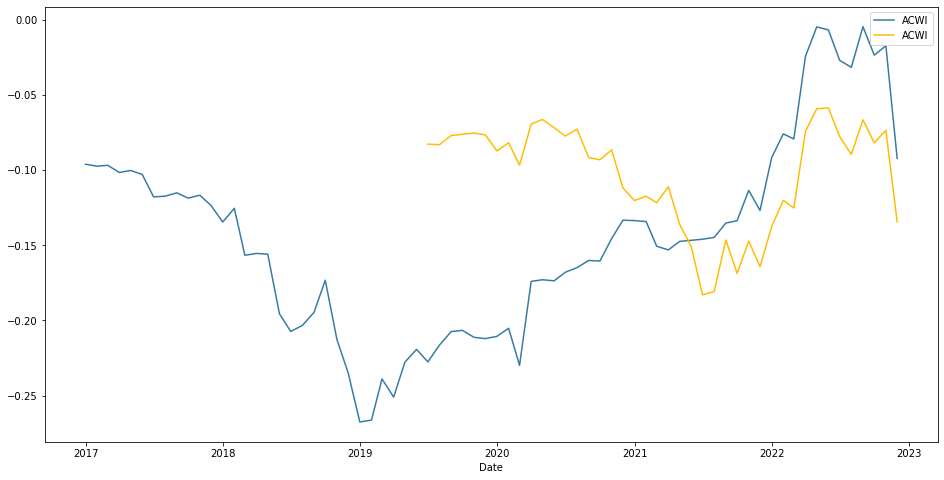

In [202]:
moving_corr = assets[['ACWI']].rolling(120).corr(assets['TBSP'])
moving_corr60 = assets[['ACWI']].rolling(150).corr(assets['TBSP'])
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=moving_corr, ax=ax, palette='mako')
sns.lineplot(data=moving_corr60, ax=ax, palette='Wistia_r')

In [268]:
portfolio_assets = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'EURO_STOXX_Leverage']]
means = pd.DataFrame(portfolio_assets.mean()*12)
cov = pd.DataFrame(portfolio_assets.cov())
portfolio_assets['01-01-2003':'01-01-2004']
portfolio_assets['01-12-2017':'01-12-2021']

,Mwig40tr,TBSP,ACWI,Gold,GABHDG
Date,,,,,
2017-02-01,10.14%,-0.13%,2.40%,3.07%,NaN
2017-03-01,4.24%,0.39%,0.03%,-2.09%,NaN
2017-04-01,-1.99%,1.33%,-2.35%,-2.23%,NaN
2017-05-01,2.48%,0.32%,-0.48%,-2.73%,NaN
2017-06-01,-0.44%,0.96%,-2.20%,-4.52%,NaN
2017-07-01,2.74%,0.15%,1.26%,0.48%,NaN
2017-08-01,1.03%,0.10%,0.14%,3.19%,NaN
2017-09-01,-0.05%,0.52%,1.97%,-2.18%,NaN
2017-10-01,1.64%,-0.02%,5.16%,1.96%,NaN


In [280]:
#assets ['Mwig40tr', 'TBSP', 'ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG', 'EURO_STOXX_Leverage', 'Fallen_Angels']
#['Mwig40tr', 'TBSP', 'ACWI', 'Gold']

porfolio_assets = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold', 'GlobalCorporate', 'GovBondG7']]
port = rp.Portfolio(porfolio_assets[-123:])



means = pd.DataFrame(portfolio_assets['01-01-2004':'01-12-2022'].mean()*12)
cov = pd.DataFrame(portfolio_assets['01-01-2004':'01-12-2022'].cov())

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

points = 15 # Number of points of the frontier
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm =  'MV' #'MV' vs 'MDD' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.00 # Risk free rate

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head(20))




,Mwig40tr,TBSP,ACWI,Gold,GlobalCorporate,GovBondG7
0,8.62%,62.59%,4.20%,1.91%,0.00%,22.68%
1,16.65%,49.65%,19.99%,8.74%,0.00%,4.96%
2,21.11%,40.55%,27.54%,10.80%,0.00%,0.00%
3,25.38%,29.93%,33.59%,11.09%,0.00%,0.00%
4,29.23%,20.39%,39.03%,11.35%,0.00%,0.00%
5,32.85%,11.40%,44.16%,11.59%,0.00%,0.00%
6,36.34%,2.76%,49.08%,11.82%,0.00%,0.00%
7,38.12%,0.00%,55.93%,5.95%,0.00%,0.00%
8,34.95%,0.00%,65.05%,0.00%,0.00%,0.00%
9,25.42%,0.00%,74.58%,0.00%,0.00%,0.00%


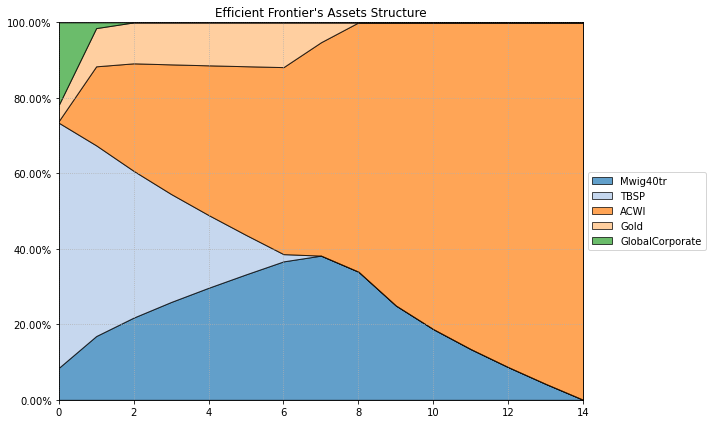

In [278]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [234]:
porfolio_assets[-150:].cov().to_numpy()
frontier.values.T
porfolio_assets[-150:].mean().values.T*12

array([0.0838378 , 0.03067022, 0.12365509, 0.06559336, 0.16379252])

In [281]:
measures = portfolioMeasures(frontier.values.T,porfolio_assets[-150:].mean().values.T, porfolio_assets[-150:].cov().to_numpy())
measures[:,0] = measures[:,0]*12
measures[:,1] = measures[:,1]*np.sqrt(12)

measures

array([[0.03903778, 0.03394494],
       [0.06099544, 0.04178119],
       [0.07127605, 0.05048165],
       [0.07927632, 0.05876569],
       [0.08646939, 0.06697663],
       [0.09324246, 0.07514715],
       [0.09975833, 0.08329194],
       [0.10502151, 0.09096976],
       [0.10974039, 0.09901806],
       [0.11353385, 0.10775471],
       [0.11609064, 0.11635439],
       [0.11823711, 0.12489035],
       [0.12016579, 0.13338461],
       [0.1219576 , 0.14184854],
       [0.12365509, 0.15028918]])

In [236]:
#params estimation
#assets ['Mwig40tr', 'TBSP', 'ACWI', 'GovBondG7', 'GlobalCorporate', 'Gold', 'GABHDG']

porfolio_assets = assets[['Mwig40tr', 'TBSP', 'ACWI', 'Gold']]
port = rp.Portfolio(porfolio_assets[-150:])

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='ledoit' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

points = 15 # Number of points of the frontier
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm =  'MV' #'MV' vs 'MDD' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.00 # Risk free rate

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head(20))


,Mwig40tr,TBSP,ACWI,Gold
0,14.15%,57.81%,15.51%,12.53%
1,21.84%,34.94%,29.77%,13.45%
2,25.38%,24.42%,36.33%,13.88%
3,28.31%,15.68%,41.78%,14.23%
4,30.97%,7.77%,46.71%,14.54%
5,33.46%,0.35%,51.34%,14.84%
6,32.35%,0.00%,59.62%,8.03%
7,31.32%,0.00%,66.37%,2.31%
8,26.86%,0.00%,73.14%,0.00%
9,21.02%,0.00%,78.98%,0.00%


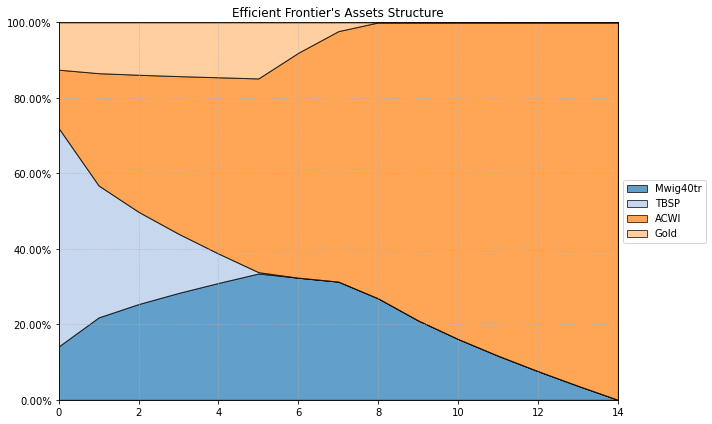

In [237]:
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

In [238]:
portfolioMeasures()

TypeError: portfolioMeasures() missing 3 required positional arguments: 'weights', 'means', and 'cov_table'